# The Soulmate Statistic
### Heartbreak, salvation, & statistical significance on NBC's *The Good Place*

This notebook is a companion to my Medium post.

*The Good Place* contains a lot of data but it isn't easy to extract. The dialogue in each episode is strewn with throw-away lines that hint at the numbers that quantify the universe depicted in the show. I wanted to get all the numerical dialogue, so I scraped the scripts from a website that posts the scripts of TV shows.

I needed intact lines of dialogue, searchable by keywords, so it wasn't necessary to use regular expressions or word vectorization. My functions scrape the scripts as strings, do just enough cleaning to make the lines readable and searchable, and organize it all to allow me to track episodes and seasons.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup #For web scraping
import time # To delay scraping 
import requests

import copy #To deep-copy dict of script strings
import random

import soulmate
from soulmate import get_season_urls, get_script, remove_linebreak, \
                    remove_whitespace, find_lines, is_topical, print_lines

#For hypothesis testing:
from scipy import stats #To find t and p values with ttests
from scipy.stats import binom # To build binomial distributions for platonic/romantic

With these functions I'm ready to get the scripts from the site.

In [3]:
#to append to the beginning of URL scraped from website
url_head = 'https://www.springfieldspringfield.co.uk/'

#Gather the URLs for each script page, by season
s01_urls = get_season_urls(url_head, 'episode_scripts.php?tv-show=the-good-place-2016&season=1')
s02_urls = get_season_urls(url_head, 'episode_scripts.php?tv-show=the-good-place-2016&season=2')
s03_urls = get_season_urls(url_head, 'episode_scripts.php?tv-show=the-good-place-2016&season=3')

#Need to correct for some inaccuracies in the episode numbering on the website.

#Step 1: 
#Get s01e01, s2e01, and s03e01
s01e01 = s01_urls.iloc[[0]]
s02e01 = s02_urls.iloc[[0]]
s03e01 = s03_urls.iloc[[0]]

#Step 2:
#Correct episode number for season 1 episode 2
s01_urls.at[0, 'episode'] += 1

#Correct episode numbers for all of season 2 and 3
s02_urls['episode'] = [ep + 1 for ep in s02_urls['episode']]    
s03_urls['episode'] = [ep + 1 for ep in s03_urls['episode']]  

#Step 3:
#Append the rest of each season to the first episode
s01_urls = pd.concat([s01e01, s01_urls], axis = 0, ignore_index = True)
s02_urls = pd.concat([s02e01, s02_urls], axis = 0, ignore_index = True)
s03_urls = pd.concat([s03e01, s03_urls], axis = 0, ignore_index = True)

#Okay, now we can continue
#Combine into one dataframe with all urls for scripts
season_urls = pd.concat([s01_urls, 
                         s02_urls, 
                         s03_urls], 
                        axis = 0, ignore_index = True)

#Remove numbering from title strings
#Should capture single- and double-digit numbers
#Iterate over each row in the season_urls DF
for index, title in enumerate(season_urls['title']):
    #Begin to iterate over each character in a title
    for i, char in enumerate(list(title)):
        #If the character is not a numeral, space, or period
        if char.isalpha():
            #Change the title to begin with this character
            season_urls.at[index, 'title'] = title[i:]
            #Stop iterating
            break

#Correct the episode titles for s1e1, s1e2, s2e2, s3e2
season_urls.at[0, 'title'] = 'Everything Is Fine' #s1e1
season_urls.at[1, 'title'] = 'Flying' #s1e2
season_urls.at[14, 'title'] += ' Part 2' #s2e2
season_urls.at[27, 'title'] += ' Part 2' #s3e2

In [4]:
#Take a look at the df that we'll use to scrape scripts
#from 39 webpages
season_urls.head()

,url,season,episode,title
0,view_episode_scripts.php?tv-show=the-good-plac...,1,1,Everything Is Fine
1,view_episode_scripts.php?tv-show=the-good-plac...,1,2,Flying
2,view_episode_scripts.php?tv-show=the-good-plac...,1,3,Tahani Al-Jamil
3,view_episode_scripts.php?tv-show=the-good-plac...,1,4,Jason Mendoza
4,view_episode_scripts.php?tv-show=the-good-plac...,1,5,Category 55 Emergency Doomsday Crisis


### Scrape scripts from the website

In [5]:
#Build dict of episode titles indexed by tuples of (season, episode)
#(Dict of scripts will be indexed by the same tuples)
titles = {(row.season, row.episode): row.title for row in season_urls.itertuples(index = False)}

#Empty dict of raw script strings
raw_scripts = {}

#Iterate over rows of the script_urls DF as tuples
#Populate dict of raw scripts
#Includes a time lag so that the remote server
#doesn't get too many requests too fast.
for row in season_urls.itertuples(index = False):
    #Script key will be a tuple of (season, episode)
    script_key = (row.season, row.episode)
    #Get script by scraping site and append to dict
    raw_scripts[script_key] = get_script(url_head, row.url)
    #Wait before pinging server again
    time.sleep(1)

In [6]:
#Correct for duplication of certain scripts by splitting them
#Chop up s1e1 and s1e2; s1e12 and s1e13; s2e1 and s2e2; and s3e1 and s3e2

#Chop up s1e1 and s1e2    line 350 and 351  What's it gonna be? [knock at door] [thunder crashes] Oh, stomachache.
raw_scripts[(1,1)] = raw_scripts[(1,1)][:21547]
raw_scripts[(1,2)] = raw_scripts[(1,2)][21547:]
#Chop up s1e12 and s1e13   (326, ' You have 30 minutes.') 21387
raw_scripts[(1,12)] = raw_scripts[(1,12)][:21387]
raw_scripts[(1,13)] = raw_scripts[(1,13)][21387:]
#Chop up s2e1 and s2e2
raw_scripts[(2,1)] = raw_scripts[(2,1)][:24800]
raw_scripts[(2,2)] = raw_scripts[(2,2)][24800:]
#Chop up s3e1 and s3e2
raw_scripts[(3,1)] = raw_scripts[(3,1)][:22554]
raw_scripts[(3,2)] = raw_scripts[(3,2)][22554:]

In [7]:
#Now we can continue
#Make a new dict of scripts to clean up
scripts = copy.deepcopy(raw_scripts)

In [8]:
#Clean all scripts to turn each into a list of strings of dialogue
for key, val in scripts.items():
    scripts[key] = clean(val)

# Looking for topics in the scripts

In [ ]:
You can look at a whole script like this.
scripts[(3,12)]

In [ ]:
#Or look up titles like this
titles[(1, 13)]

In [36]:
#Make a list of topics you want to look for.
number_words = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', ' ten ',
           'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen',
           'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
            'hundred', 'thousand', 'million', 'billion', 'trilion',
            'first', 'second', 'third', 'fifth', 'ninth']
#Then call find_lines on the dict of scripts to hunt for your topics.
#A new dict of script with only the topical lines will be returned.
number_lines = find_lines(number_words, scripts, numerals = True)

#Then you can look at all the relevant lines, or just the relevant lines from one script.
number_lines[(1,6)]

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 [upbeat music] - What are you doing? - [gasps] Dude, I\'m freaked out about my meeting with Michael, and if I spend one more second staring at Creepo the Clown, I\'m gonna lose it.'),
 (5,
  " In five minutes, Michael wants my help investigating what's making the neighborhood go nuts, which is obviously me."),
 (17, ' Well, my first rule would be that no one can veto my rules.'),
 (30, " [clears throat] Oh, I forgot, you don't see in nine dimensions."),
 (38, ' I even watched all ten seasons of the show "Friends.'),
 (87,
  " So couples date! Let's go! I never really looked around your office the first day."),
 (96, ' These 78 are the most suspicious.'),
 (121, ' They are a couple, and I am a third part of that couple.'),
 (123, " It's a three-person couple."),
 (140,
  ' I thought transition would be easier if the architect were on-site for at least the first 1,000 years or so.'),
 (152,
  " Now, what should we do first

# Michael's attempt log

In [40]:
temporal = ['point', 'points', 'second', 'seconds',  'minute',
              'minutes', 'day', 'days', 'week', 'weeks', 
              'month', 'months', 'year', 'years', 'time', 'times',
             'people', 'humans', 'attempt', 'attempts',
              'try', 'tries', 'version', 'versions']
all_temporal = find_lines(temporal, number_lines)
print_lines(titles, all_temporal)

(1, 1)
Everything Is Fine
(42, ' Each one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance.')
(57, ' - And welcome to your first day in the afterlife.')
(76, " You know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day.")
(148, ' I was the top salesperson five years running.')
(175, " [people yelling and screaming, mechanical buzzing] - The bear has two mouths! - [people screaming] [sound stops] Well, it doesn't sound awesome.")
(217, ' Do you have a second to talk about the environment? Do you have a second to eat my farts? You missed.')
(233, '" And I know we just met on this bus ten minutes ago, but he seemed nice.')
(238, ' I had been an apprentice for over 200 years, and my boss has finally given me my first solo project.')


(1, 2)
Flying
(35, ' That was my first time as a fashion "don\'t," and I did not care for it.')
(84, ' Welcome to orientation, day two.')


In [43]:
three00 = ['300', 'three hundred']
three00_lines = find_lines(three00, scripts)
print_lines(titles, three00_lines)

(1, 6)
What We Owe to Each Other
(204, ' And do you like France as much as I do? Well, they enslaved my country for 300 years.')


(1, 11)
What's My Motivation
(305, ' I just have to run home real quick and hit save on the Madden game I was playing because Blake Bortles has, like, 300 yards passing in the first half [hissing] [tense music] Shawn.')


(3, 2)
Everything Is Bonzer! Part 2
(292, ' Just binged like 300 episodes of "NCIS.')


(3, 5)
Jeremy Bearimy
(62, ' Almost 300, actually.')


(3, 10)
Janet(s)
(95, " Eleanor, how'd you know I always wanted a dog like this? Funny story, it's one of the things I saw in the alternate timeline, where we were soul mates on and off for 300 years.")
(112, ' Negative 4,300.')
(336, ' No offense, dude, but you have told us a lot of lies in the last 300 years.')




### Lines with data about the attempts:

S2 ep 4, Team Cockroach:

How many different versions of this place have we been through? Uh, let's see."),
 (94, ' 802.'),
 (95, ' The longest one was 11 months.'),
 (96, ' Uh, this current one has only been going for one week.'),
 (97, ' Boy, you guys barely know each other.'),
 (98, " It's gonna make this tough."),
 (99, " What's that super tiny line? That's the shortest one, eight seconds."),
 (100, ' It was a butt reboot.'),
 (101, ' I sat on the activator by mistake.')
 
 s3 ep 5, Jeremy Bearimy:
 
 So all the attempts you made to torture us we must have been in the afterlife for 100 years.'),
 (62, ' Almost 300, actually.')
 
### Reconstructing the distribution

Armed with this data, we can create a distribution with parameters similar to Michael's and then plot it.

In [44]:
random.seed(11)

#We don't know the mean or standard deviation

#How long it took Eleanor to figure out she wasn't in The Good Place
#max: 11 months  at 770th attempt
max_ = 334
max_index = (771)

#min: 8 seconds at 556th attempt
min_ = 8 / 86400
min_index = (557)

#total attempts: 802
pop_size = 802

#This distribution gets pretty close. 
#Use 800 random values with a max of 9 1/4 months.
attempts = np.random.randint(low = 10, high = 277, size = pop_size - 2)

#manually add an 8-second value and an 11-month value.
attempts = np.insert(attempts, min_index, min_)
attempts = np.insert(attempts, max_index, max_)

#All attempts together should add up to around 300 years
attempts.sum() / 365

311.6794520547945

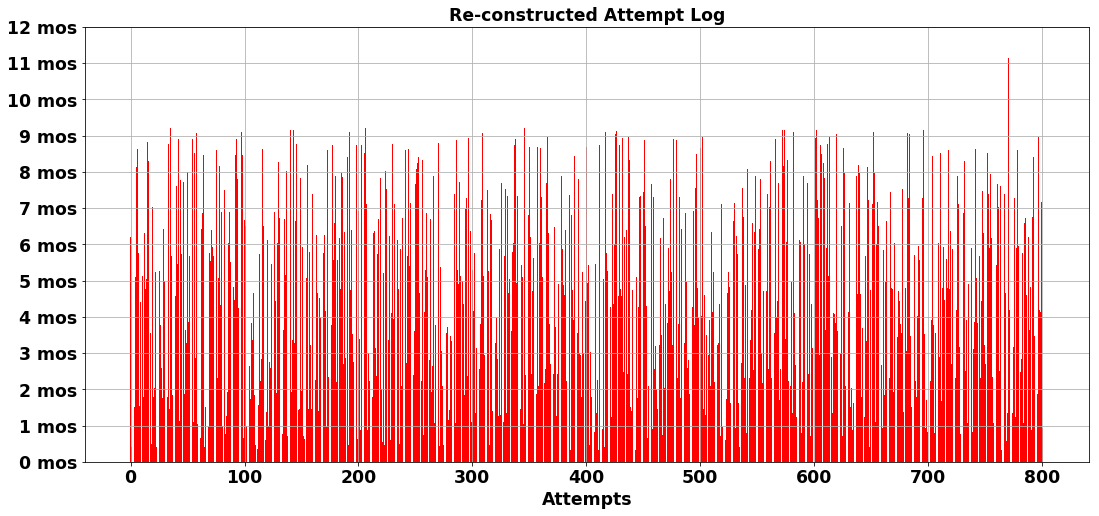

In [82]:
#Plot attempts as bar graph
kwargs = {'fontsize': 'xx-large',
          'fontweight': 'extra bold'}
#Set y ticks to resemble the ones in the screenshot
yticks = np.arange(0, 390, 30)
ylabels = [str(x) + ' mos' for x in np.arange(0, 13, 1)]
#Draw figure
fig = plt.figure(figsize = (18,8))
#Draw a grid like in the screenshot
plt.grid()
#Draw a bar graph like in the screenshot
plt.bar(range(pop_size), attempts, color = 'red')
plt.xlabel('Attempts', **kwargs)
plt.xticks(**kwargs)
plt.yticks(yticks, ylabels, **kwargs)
plt.title('Re-constructed Attempt Log', **kwargs)
plt.show()

![attemptlogsmall.png](https://raw.githubusercontent.com/ssrosa/the_soulmate_statistic/master/attemptlogsmall.png)

Not bad! With this distribution we can now run statistical tests.

### Hypothesis test: one-sample t test with one tail

s01e12, 'Mindy St. Claire':

(562, Michael: 'I think that we can get them to torture each other for 1,000 years.')
(563, Sean: 'I think you'll be lucky to get six months out of this insane gambit.')

Michael's guess is too far off to be worth testing. Sean's is much closer to the observed mean of the distribution. 'I think you'll be lucky to get six months out of this insane gambit' is like saying 'I predict you will get less than six months.'

"You will get six months or more"
 
**Null hypothesis: mu ≥ 6 months**

"You will get less than six months"

**Alternative hypothesis: mu < 6 months**

In [89]:
alpha = 0.05
seans_mean = (31 * 3) + (30 * 2) + 28 #181 days
michaels_mean = 365 * 1000 #1000 years

#Test Sean's mean using Scipy's one-sample t test
test_statistic, pvalue = stats.ttest_1samp(attempts, seans_mean)
print('Test statistic:', test_statistic)
print('P value:', pvalue)
print('Sean\'s mean:', seans_mean, 'days')
print('Sample mean:', attempts.mean(), 'days')
print('P less than alpha?', alpha > pvalue)

Test statistic: -14.097128359512485
P value: 1.7807626586630457e-40
Sean's mean: 181 days
Sample mean: 141.8491271820449 days
P less than alpha? True


### Results

Sean's guess was right. The p value is less than the alpha so we reject the null hypothesis that the neighborhood can last as long as or longer than 6 months.

In [91]:
#Build a new distribution using a 1000 means of random samples of size 30 from attempts.
sampled_attempts = [np.random.choice(attempts, size = 30, replace = True).mean() for i in range(1000)]

In [ ]:
len(sampled_attempts)

In [ ]:
sampled_attempts[950]

In [ ]:
 upper_bound = np.percentile(sampled_attempts, 97.5)

In [ ]:
fig = plt.figure(figsize = (18,8))
sns.distplot(sampled_attempts, color = 'red')
kwargs = {'c': 'darkgreen',
          'label': 'average length',
          'linewidth': 10
        }
plt.axvline(x = attempts.mean(), ymax = 0.9, **kwargs)



kwargs = {'c': 'red',
          'label': 'alpha',
          'linewidth': 10
        }
plt.axvline(x = upper_bound, ymax = 1, **kwargs)

kwargs = {'c': 'lightgreen',
          'label': 'Sean\'s prediction',
          'linewidth': 10
        }
plt.axvline(x = seans_mean, ymax = 0.9, **kwargs)
plt.show()

<a id = 'chidi_eleanor'></a>

# Chidi and Eleanor fall in love

In [88]:
falling = ['have feelings for', 'I love you', 'I think I love you', 'mates']
falling_lines = find_lines(falling, scripts)
print_lines(titles, falling_lines)

(1, 1)
Everything Is Fine
(71, ' Soul mates are real.')
(121, ' And now we can actually learn about them together as soul mates.')
(189, ' They are soul mates and your next-door neighbors.')
(191, " Can I just say I love your house? It's just so tiny and cute.")


(1, 4)
Jason Mendoza
(327, ' Soul mates sometimes take months to really click.')


(1, 5)
Category 55 Emergency Doomsday Crisis
(113, " It's an impossible position! You know what, if you're so stressed from writing on a chalkboard, why don't you just leave? We can pretend to be soul mates in public, but other than that, we don't have to see each other! Fine with me! I'll move out right now.")
(300, " I know we'll never be soul mates, but we're friends.")


(1, 6)
What We Owe to Each Other
(212, " Oh, uh, we're not soul mates.")


(1, 7)
The Eternal Shriek
(292, " What did you want to say to me? Oh, um just that I'm here and I love you, man.")
(293, ' I love you, too, boot brother.')
(346, ' [breathing deeply] Hey, I love you,

s02e04, Team Cockroach'

Eleanor: 'How many times in all the reboots did I ask Chidi for help, he refused to help me and then I had to get better on my own?'
Michael: 'Never. He always helped you.'
Eleanor: 'God. Really?'
Michael: ' Yep. No matter how I set it up, you found him, confessed you didn't belong, asked him for help, and he said yes. Now his agreeing to help was part of my plan. What wasn't part of my plan was it actually working. Drove me nuts. Pesky little nerd.')

s03e07, A Fractured Inheritance

 (337,
  ' In one of the reboots, you and Chidi fell in love deeply, and you told him that you loved him, and he told you that he loved you back.')#Mihael tells Eleanor about falling in love with Chidi in reboot 119

s03e08, The Worst Possible Use of Free Will

Michael: 'So now I can show you the highlights of reboot 119.'
Eleanor: 'Oh, yeah? We know this is, like, the hundredth time you've tried to torture us, but this time it's different, because we're in love. And love is stronger than anything you can throw at us. No matter what he does, we will find each other, and we will help each other, because we're soul mates.'
Michael: 'I put you and Chidi in close proximity, because I needed you to drive each other crazy. But I never intended for you to fall in love.'

### Reconstructing a probability distribution

All we really know is that they fell in love once out of 801 attempts. Visualizing it gives us a sense of the rarity of the event.

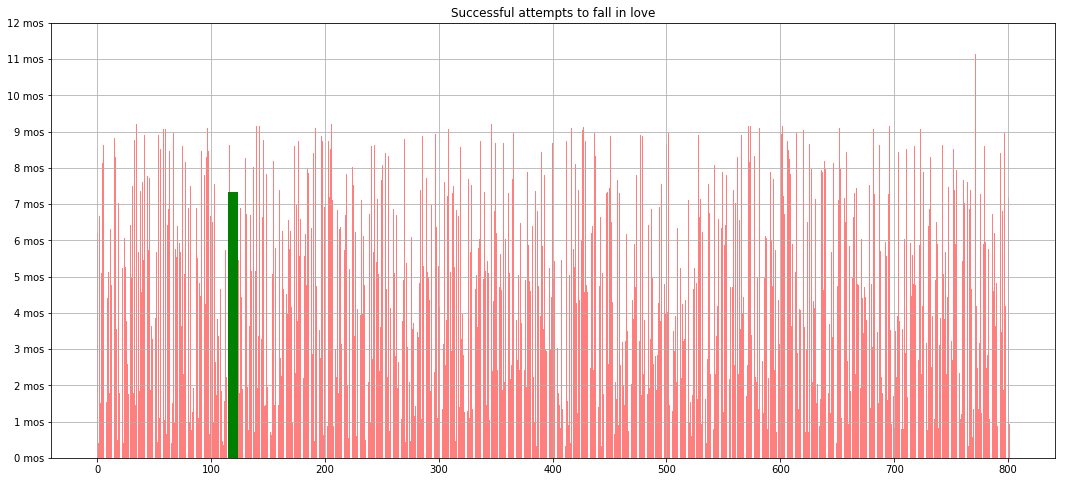

In [85]:
#Plot attempts with one success at being soulmates
fig = plt.figure(figsize = (18,8))
plt.grid()
kwargs = {'alpha': 0.5}
plt.bar(range(pop_size), attempts, color = 'red', **kwargs)
#Attempt 119 (soulmates) in green
kwargs = {'color': 'green',
          'label': 'soulmates',
          'linewidth': 10
        }
plt.axvline(x = 119, ymax = 0.6, **kwargs)
plt.yticks(yticks, ylabels)
plt.title('Successful attempts to fall in love')
plt.show()

In [ ]:
k = np.arange(801)
n = 801
p = (1/81)

binom = stats.binom.pmf(k, n, p)
binom

In [ ]:
k = np.arange(802)
n = 802
p = (1/81)

binom = stats.binom.pmf(k, n, p)

fig = plt.figure(figsize = (15,8))
plt.plot(k, binom)
plt.xlabel('Number of successes')
plt.ylabel('Probability of success')
plt.show()

In [ ]:
sim = stats.binom.rvs(n, p, size = 801)
print('Mean:', np.mean(sim))
plt.hist(sim, bins = 20, normed = True)

In [ ]:
sim = stats.binom.rvs(n, p = (1/81), size = 801)
print('Mean:', np.mean(sim))
plt.hist(sim, bins = 30, normed = True)

In [ ]:
#probability of falling in love
p = (1 / 802)

#Number of trials
n = 803

np = p * n

var = np * (1 - p)

var

In [ ]:
#binomials:
#repeated trials
#two outcomes
#p success is constant
#indepedent

#binomial random variable is the number of successes observed in an experiment
#outcomes           binomial probabliitiy
#...
#...
#fall in love once P(X = 1)

#P =           n!      * p^x * (1 - P)^n -x
#        x!(n - x)!
factorials = ((math.factorial(802)) / (math.factorial(1) * math.factorial(801)))

In [ ]:
factorials * 0.5**1 * (0.5)**801

In [ ]:
#Bayes
#Posterior = Likelihood * Prior / Hypothesis

#P(A) = prior
#P(B|A) = likelihood.
#                Data (A) are given and fixed, hypothesis (b) varies.
#P(A|B) = posterior.
#                Hypothesis is fixed, data vary.
#                Data (A) are given and variying, hypothesis (B) is fixed.

#Prior is (A) falling love 1/802 times
#Likelihood of falling in love (B) 2/803 times given fell in love (A) 1/802 times

#(1/802) * (2/803 given 1/802)
# divided by 2/803

In [ ]:
1 / 802

In [ ]:
p

In [ ]:
#Distribution of falling in love in Michael's neighborhood
love_dist = np.zeros(801)
#Attempt 119: fell in love
love_dist[119] = 1

In [ ]:
n = 801

In [ ]:
binom.ppf(0.99, n, p181)

In [ ]:
love_181

In [ ]:
p181 = (1 / 81)
love_181 = np.arange(binom.ppf(0.01, n, p181),
                    binom.ppf(0.99, n, p181), 0.1)
fig, ax = plt.subplots(1, 1)
ax.plot(love_181, binom.pmf(love_181, n, p181), 'bo', ms=8, label='binom pmf')
#ax.vlines(love_181, 0, binom.pmf(love_181, n, p181), colors='b', lw=5, alpha=0.5)
plt.show()

In [ ]:
p1801 = (1/801)
p18001 = (1 / 8001)
love_1801 = np.arange(binom.ppf(0.01, n, p1801),
                    binom.ppf(0.99, n, p1801))
fig, ax = plt.subplots(1, 1)
ax.plot(love_1801, binom.pmf(love_1801, n, p1801), 'bo', ms=8, label='binom pmf')
#ax.vlines(love_181, 0, binom.pmf(love_181, n, p181), colors='b', lw=5, alpha=0.5)
plt.show()

In [ ]:
love_181 = bernoulli.rvs(size = n, p = p181)
ax = sns.distplot(love_181,
                 kde = False,
                 #color = ,
                 hist_kws ={'linewidth' : 15,
                           'alpha': 1})
ax.set(xlabel = 'Falling in love, probability of success 1/81', 
       ylabel = 'Trials')

In [ ]:
p18001

In [ ]:
#1 / 8001
fig = plt.figure(figsize = (12,8))
love_18001 = bernoulli.rvs(size = n, p = 1/81)
#Plot
ax = sns.distplot(love_18001,
                 kde = False,
                 #color = ,
                 hist_kws ={'linewidth' : 15,
                           'alpha': 1})
ax.set(xlabel = 'Falling in love, probability of success 1/81', 
       ylabel = 'Trials')

<a id = 'pointstogetin'></a>

[(Back to top)](#top)

# Points to get in

520000 at 68 years old is "terrible"; "he's screwed"

Lady from video in Michael's first fake neighborhood: 999276

Figures for Michael's first fake neighborhood:

Average for resident: 1222821

Low: 997485

High: 2987309

2707234

2655118

2635744

2588673

In [25]:
#people good people good
people_good = ['People good']
people_good_lines = find_lines(people_good, scripts)
print_lines(titles, people_good_lines)

(2, 6)
The Trolley Problem
(26, ' - People good.')
(27, ' People good.')




In [ ]:
#Saddest moment
saddest = ['saddest']
saddest_lines = find_lines(saddest, scripts)
print_lines(titles, saddest_lines)

In [ ]:
#That wasn't me who fell in love with you.
wasnt = ['Wikipedia']
wasnt_lines = find_lines(wasnt, scripts)
print_lines(titles, wasnt_lines)

season 3 episode 10

 (147, ' Conceptions of the self.'),
 (148,
  " Let's start with John Locke, who believed that personal identity was based on having a continued consciousness essentially, memory."),
 (149, ' Memories are links in a chain that together form a single self.'),
 (150,
  " If I can't remember what happened because it happened to a Chidi from another timeline, it's not a unified me."),
 (151,
  " Just because you don't remember doing something doesn't mean you didn't do it."),
 (152,
  ' I have no idea how it happened, but there is definitely a tattoo on my butt that says "Jasom.'),
 (153, '" That leads us to Derek Parfit.'),
 (154,
  " - It does? - Parfit said even if I have memories from an earlier time, that doesn't necessarily mean it was me."),
 (155,
  " After all, if my brain was split in two and each half was put in a different person, which one is me? All I know is that other Chidi doesn't exist anymore, and this one does."),
 (156, ' So this must be the real Chidi.'),

In [24]:
#I was just torturing William Shakespeare...
shakespeare = ['Entourage']
shakespeare_lines = find_lines(shakespeare, scripts)
print_lines(titles, shakespeare_lines)

(3, 12)
Chidi Sees the Time-Knife
(135, ' I was just in the middle of torturing William Shakespeare by describing the plot to the "Entourage" movie.')




# The Perfect System

In [ ]:
the_system = ['system']
system_lines = find_lines(the_system, scripts)
print_lines(titles, system_lines)

s01e01, Everything Is Fine

(64, ' [laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.')
(83, " Again, it's an incredibly selective system.")
(370, " See, that's the trouble with these perfect systems.")

s01e08, Most Improved Player

(4, " Our system has never made a mistake before It's just not possible.")


s02e01, Everything is Great!

(180, " Now, normally, our omniscient system perfectly analyzes each person's profile, and then matches him or her with another person.")

s03e010, Janet(s)

(136, ' [whooshing] The system is flawless, and tampering is quite impossible.')

# The Time-Knife

In [ ]:
#Time-Kinfe
timeknife = ['Time-Knife']
timeknife_lines = find_lines(timeknife, scripts)
print_lines(titles, timeknife_lines)

# Boat on a lake

In [ ]:
#Boat on a lake, red wine, French poetry
redwine = ['poetry']
redwine_lines = find_lines(redwine, scripts)
print_lines(titles, redwine_lines)

# Future work: Janet

In [ ]:
janet = ['janet', 'robot', 'know everything about', 'knowledge', 'updat', 'database']
janet_lines = find_lines(janet, scripts)
print_lines(titles, janet_lines)

I didn't get to use this for my article on soulmates but it interesting to think about. Could be good for another article.

s01e01, Everything Is Fine

(161, " She's like this walking database.")

s01e07, The Eternal Shriek

(181, ' Each new update of Janet gains more wisdom and social abilities.')
(207, ' I am simply an anthropomorphized vessel of knowledge built to make your life easier.')
(272, " Uh, her memory must have been wiped clean, so now she's gonna have to re-upload all the knowledge in the universe, which will only take a few days.")

s01e09
(146, " I mean, it does matter if I know things, because I'm an informational delivery system, and I don't have a heart, but thanks.")

s01e10, Chidi's Choice

(288, '" - [gags] - "Jacksonville Jaguars rule!" Jason, when I was rebooted, and I lost all my knowledge, I was confused and disoriented, but you were always kind to me.')

s01e11, What's My Motivation

(113, ' As you know, each time I am updated, I accrue new knowledge and abilities.')

s02e06, The Trolley Problem

(75, ' I am simply a vessel containing all of the knowledge in the universe.')

s02e07, Janet and Michael

(191, ' Say what now? After the very first time you were rebooted, and as you were slowly regaining your knowledge, you bonded with Jason.')

(358, " You contain all the knowledge in the universe, you have a rippin' bod, and you can literally do anything.")

s02e10, Best Self

(138, ' In case you were wondering, I am by definition the best version of myself, because my operating system is always updating.')

s02e12, The Burrito

(47, " Wait, you don't already know everything about us? You're not omniscient? Well Not in the way you mean.")

s03e03, The Brainy Bunch

(127, ' Ever since we walked through that portal, my knowledge has stopped updating.')

s03e06, The Ballad of Donkey Doug

(29, ' I do know everything about you and Simone and computer programming and virtual reality and artificial intelligence and the human brain and everything else.')

s03e13, Pandemonium

(43, ' Janet is a walking database of all the knowledge in the universe, and since you, John, seem to like asking a relentless number of questions, go ahead.')

# Future work: the points system

In [ ]:
points = [' points', ' earn', ' lose', 'lost', 'losing']
points_lines = find_lines(points, number_lines)
print_lines(titles, points_lines)

If you'd like to investigate the point system, and maybe figure out how many points it takes to get into the Good Place, you can use this code. I couldn't figure it out based on the dialogue available in seasons 1 through 3.

s01e11, What's My Motivation

(9, ' Now, the average point total for a resident here is roughly 1.2 million.')
 
s3e10, Janet(s)
 
 (165,
  " Can you just tell me his total so far? Looks like he's at 520,000 points."),
 (166, ' - Well done, Doug.'),
 (167, " - So that's that's good? Oh, it's excellent."),
 (168, " Wait, he's 68 years old? Oh, that's terrible."),
 (169, " He's screwed."),